<a href="https://colab.research.google.com/github/diamartinezpa/cadenas_markov/blob/main/Tarea_1_02_de_Abril_Cadenas_de_Markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega Trabajo 1 - Cadenas de Markov & Aplicaciones

Grupo 8:
- Diego Fernando Pinzón López - dfpinzonl@unal.edu.co
- Diego Andrés Martínez Parada - diamartinezpa@unal.edu.co

# Descripción Tarea 1

Escriba un notebook realizando los siguientes experimentos:

### **1)** Implementar el algoritmo (Gibbs Sampler) visto en clase para generar muestras de una distribución uniforme sobre las configuraciones factibles del modelo Hard-Core, en la rejilla cuadrada $k \times k$, ($\approx 3 \leq k \leq 20$). Lo ideal es que se puedan visualizar las muestras y algunos pasos de la trayectoria de la cadena de Markov que condujo a la muestra (Sugerencia: tome $X_{10.000}$ ó $X_{100.000}$ como tiempo final).

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

##### Función que permite ver si una configuración (array k x k de unos y ceros) es una configuración factible, es decir, si satisface las condiciones del modelo Hard-Core


In [2]:
def configuracion_factible(configuracion):
    for i in range(len(configuracion)):
        for j in range(len(configuracion)):
            # Verificar que no haya ningún color repetido adyacente en la celda donde sí hay un 1
            if configuracion[i][j] == 1:
              if (i > 0 and configuracion[i-1][j] == 1) or \
                 (i < len(configuracion)-1 and configuracion[i+1][j] == 1) or \
                 (j > 0 and configuracion[i][j-1] == 1) or \
                 (j < len(configuracion)-1 and configuracion[i][j+1] == 1):
                 return False
    return True

##### Comprobación con ejemplos de la ejecución de la función

In [3]:
conf_ejemplo_1 = np.array([[1,0,0]
                          ,[0,1,0]
                          ,[0,0,1]])
print(conf_ejemplo_1)
configuracion_factible(conf_ejemplo_1)

[[1 0 0]
 [0 1 0]
 [0 0 1]]


True

In [4]:
conf_ejemplo_2 = np.array([[1,0,0]
                          ,[1,0,0]
                          ,[0,0,0]])
print(conf_ejemplo_2)
configuracion_factible(conf_ejemplo_2)

[[1 0 0]
 [1 0 0]
 [0 0 0]]


False

#### Funciones que permiten generar una configuración (array k x k de unos y ceros) factible, es decir, que satisface las condiciones del modelo Hard-Core

In [6]:
#Recibe una configuración inicial y la posición i,j del array, retorna una
#configuración después de generar la verificación de los vecinos
def cambio_colores(configuracion,i,j):
    # Verificar que no haya ningún 1 adyacente en la celda donde sí hay un 1
    if (i > 0 and configuracion[i-1][j] == 1) or\
       (i < len(configuracion)-1 and configuracion[i+1][j] == 1) or\
       (j > 0 and configuracion[i][j-1] == 1) or\
       (j < len(configuracion)-1 and configuracion[i][j+1] == 1):
         configuracion[i][j] = 0

    else:
      a = random.choice([0, 1])
      configuracion[i][j] = a

    return configuracion

In [7]:
#Argumento de la función: tamaño de la matriz, retorna una configuración válida
def generador_configuracion_factible(k):
    configuracion = np.full((k, k), 0, dtype=int)

    for i in range(k):
        for j in range(k):
            configuracion = cambio_colores(configuracion, i, j)
    # Verificar si la configuración generada es factible
    while not configuracion_factible(configuracion):
        configuracion = generador_configuracion_factible(k)     # Vuelve a llamar la función hasta que se tenga una configuración factible
    return configuracion

### Ejecución de la función para generar una configuración factible con $k=10$

In [8]:
generador_configuracion_factible(10)

array([[0, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]])

#### Otro ejemplo de configuración factible con $k=30$: y con visualización para fácil comprobación

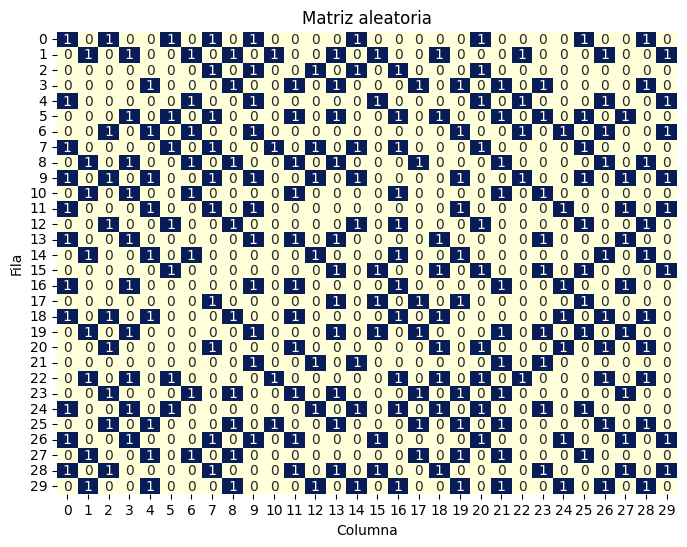

In [ ]:
configuracion_mapa = generador_configuracion_factible(k = 30)

plt.figure(figsize=(8, 6))
sns.heatmap(configuracion_mapa
           ,annot = True
           ,fmt = "d"
           ,cmap = "YlGnBu"
           ,cbar=False)
plt.title("Matriz aleatoria")
plt.xlabel("Columna")
plt.ylabel("Fila")
plt.show()

### Función que implementa del **algoritmo Gibbs Sampler** para generar muestras de una distribución uniforme


In [9]:
## Ingresa un valor de n que serían la cantidad de iteraciones y k como tamaño de la matriz que deseamos
def algoritmo_gibbs(n,k):
    # Lista de muestras de configuraciones factibles dentro del algoritmo gibbs
    muestras = []
    # Lista del número de partículas dentro de cada configuración factible
    num_particulas = []
    # Generar una configuración inicial aleatoria válida
    configuracion_actual = generador_configuracion_factible(k)

    for w in range(n):
        configuracion_propuesta = configuracion_actual.copy()
        i, j = random.randint(0, k-1), random.randint(0, k-1)               # Elegir una posición aleatoria en la configuración actual
        configuracion_propuesta[i][j] = 1 - configuracion_propuesta[i][j]

        particulas_conf_actual = np.count_nonzero(configuracion_actual == 1)
        particulas_conf_propuesta = np.count_nonzero(configuracion_propuesta == 1)

        if configuracion_factible(configuracion_propuesta):
          muestras.append(configuracion_propuesta)            # Agregar la configuración actual a las muestras
          num_particulas.append(particulas_conf_propuesta)
          configuracion_actual = configuracion_propuesta.copy()
        else:
          muestras.append(configuracion_actual)
          num_particulas.append(particulas_conf_propuesta)

    sum_num_particulas = sum(num_particulas)
    len_num_particulas = len(num_particulas)
    total_avg = round(sum_num_particulas/len_num_particulas,2)
    return muestras, total_avg

#### El algoritmo construido nos retorna $n=10$ muestras para $k=3$ y además el promedio particulas en todas las muestras.

In [10]:
algoritmo_gibbs(n = 10, k = 3)[0]

[array([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 1]]),
 array([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 1]]),
 array([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 0, 1],
        [0, 0, 0],
        [0, 1, 0]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 1, 0]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 1]])]

In [11]:
algoritmo_gibbs(n = 10, k = 3)[1]

2.7

### **2)** Usar muestras generadas con lo hecho en el ejercicio anterior para estimar el número de partículas "típico" que tienen una configuración factible en la rejilla $k \times k$. Veriticar como cambia el histograma si en el paso 1) se toman en vez de $X_{10.000}$ ó $X_{100.000}$, otros tiempos de la cadena ${X_A}$

#### En el siguiente código se generan las iteraciones desde $10$ hasta $100.000$ con el algoritmo de gibs para $k=3$

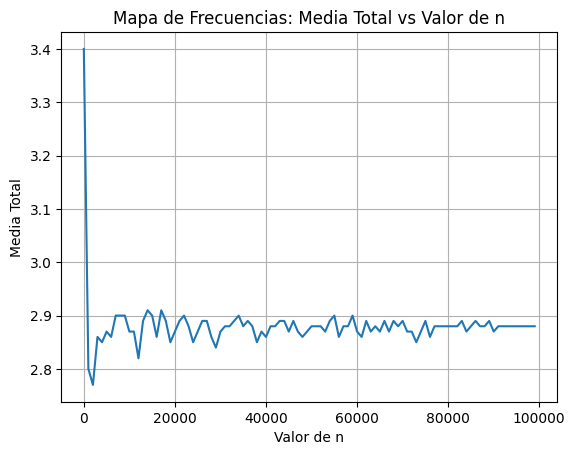

In [12]:
# Calcular los promedios totales para diferentes valores de n
n_values = list(range(10, 100000, 1000))
total_avgs = []

for x in n_values:
  total_avg_insert = algoritmo_gibbs(n = x, k=3)[1]
  total_avgs.append(total_avg_insert)

# Graficar el mapa de frecuencias
plt.plot(n_values, total_avgs)
plt.xlabel('Valor de n')
plt.ylabel('Media Total')
plt.title('Mapa de Frecuencias: Media Total vs Valor de n')
plt.grid(True)
plt.show()

#### **3)** Replicar lo hecho en el punto 1) para $q$ coloraciones ($ 2 \leq q \leq 10$, $3 \leq k \leq 20$).

#### Función que nos permite cambiar los colores o no, estando en una posición i,j de una configuración inicial

In [19]:
## Ingresa una configuración inicial, una posición i,j y un listado de colores
## retorna una configuración
def cambio_colores(configuracion,i,j,lista_colores_q):
    #Me trae el color de la casilla i,j
    color_q = configuracion[i][j]
    lista_colores_excluir = []
    # Verificar que no haya ningún 1 adyacente en la celda donde sí hay un 1
    if (i > 0 and configuracion[i-1][j] == color_q) or\
       (i < len(configuracion)-1 and configuracion[i+1][j] == color_q) or\
       (j > 0 and configuracion[i][j-1] == color_q) or\
       (j < len(configuracion)-1 and configuracion[i][j+1] == color_q):
         if i > 0:
                color_q1 = configuracion[i-1][j]
                lista_colores_excluir.append(color_q1)

         if i < len(configuracion)-1:
                color_q2 = configuracion[i+1][j]
                lista_colores_excluir.append(color_q2)

         if j > 0:
            color_q3 = configuracion[i][j-1]
            lista_colores_excluir.append(color_q3)

         if j < len(configuracion)-1:
                color_q4 = configuracion[i][j+1]
                lista_colores_excluir.append(color_q4)

         lista_sin_color_q = [x for x in lista_colores_q if x not in lista_colores_excluir]
         color_q_nuevo = random.choice(lista_sin_color_q)
         configuracion[i][j] = color_q_nuevo

    if i == len(configuracion)-1 and j == len(configuracion)-1:
        lista_colores_excluir = [configuracion[i][j-1], configuracion[i-1][j]]
        lista_sin_color_q = [x for x in lista_colores_q if x not in lista_colores_excluir]
        color_q_nuevo = random.choice(lista_sin_color_q)
        configuracion[i][j] = color_q_nuevo

    return configuracion

### Función que verifica si es una configuración factible con las condiciones del problema de $q$-coloraciones

In [20]:
## ingresa una configuración incial retorna un booleano
def configuracion_factible(configuracion):
    for i in range(len(configuracion)):
        for j in range(len(configuracion)):
            l = configuracion[i][j]
            # Verificar que no haya ningún color repetido adyacente en la celda donde sí hay un 1
            if (i > 0 and configuracion[i-1][j] == l) or \
               (i < len(configuracion)-1 and configuracion[i+1][j] == l) or \
               (j > 0 and configuracion[i][j-1] == l) or \
               (j < len(configuracion)-1 and configuracion[i][j+1] == l):
                return False
    return True

#### Función que genera una configuración factible para el problema de $q$-coloraciones

In [21]:
def generador_configuracion_factible(k,q):
    lista_colores_q = [a for a in range(q)]
    configuracion = np.full((k, k), -1, dtype=int)

    for i in range(k):
        for j in range(k):
            configuracion = cambio_colores(configuracion, i, j, lista_colores_q)
    # Verificar si la configuración generada es factible
    while not configuracion_factible(configuracion):
        configuracion = generador_configuracion_factible(k,q)     # Vuelve a llamar la función hasta que se tenga una configuración factible
    return configuracion

#### Generación de una configuración factible para $k=10$ y $q=4$ se genera un diagrama para observar mas facilmente que se cumplen las condiciones de una $q$-coloración

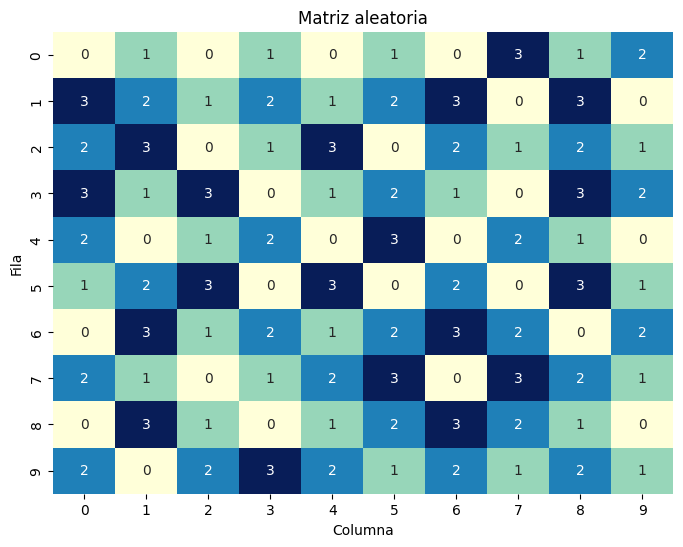

In [22]:
configuracion_mapa = generador_configuracion_factible(k = 10, q = 4)

plt.figure(figsize=(8, 6))
sns.heatmap(configuracion_mapa
           ,annot = True
           ,fmt = "d"
           ,cmap = "YlGnBu"
           ,cbar=False)
plt.title("Matriz aleatoria")
plt.xlabel("Columna")
plt.ylabel("Fila")
plt.show()

#### Función que implementa del algoritmo **Gibbs Sampler** para generar muestras de una distribución

In [27]:
#Ingresa la cantidad de iteraciones n, una configuración inicial y q que es la
#cantidad de colores

def algoritmo_gibbs(n, configuracion, q):
    # Lista de muestras de configuraciones factibles dentro del algoritmo gibbs
    muestras = []
    # Lista del número de partículas dentro de cada configuración factible
    num_particulas = []
    # Generar una configuración inicial aleatoria válida
    configuracion_actual = configuracion

    lista_colores_q = [a for a in range(q)]

    k = len(configuracion)

    for w in range(n):
        configuracion_propuesta = configuracion_actual.copy()
        i, j = random.randint(0, k-1), random.randint(0, k-1)               # Elegir una posición aleatoria en la configuración actual
        color_q = configuracion_propuesta[i][j]
        lista_sin_color_q = [x for x in lista_colores_q if x!= color_q]
        nuevo_color_q = random.choice(lista_sin_color_q)
        configuracion_propuesta[i][j] = nuevo_color_q

        if configuracion_factible(configuracion_propuesta):
            muestras.append(configuracion_propuesta)            # Agregar la configuración actual a las muestras
            configuracion_actual = configuracion_propuesta.copy()
        else:
            muestras.append(configuracion_actual)
            #num_particulas.append(particulas_conf_propuesta)

    #sum_num_particulas = sum(num_particulas)
    #len_num_particulas = len(num_particulas)
    #total_avg = round(sum_num_particulas/len_num_particulas,2)
    return muestras

#### Muestras del algoritmo de Gibbs

In [31]:
algoritmo_gibbs(10, configuracion_mapa, 4)[0]

[array([[0, 1, 0, 1, 0, 1, 0, 3, 1, 2],
        [3, 2, 1, 2, 1, 2, 3, 0, 3, 0],
        [2, 3, 0, 1, 3, 0, 2, 1, 2, 1],
        [3, 1, 3, 0, 1, 2, 1, 0, 3, 2],
        [2, 0, 1, 2, 0, 3, 0, 2, 1, 0],
        [1, 2, 3, 0, 3, 0, 2, 0, 3, 1],
        [0, 3, 1, 2, 1, 2, 3, 2, 0, 2],
        [2, 1, 0, 1, 2, 3, 0, 3, 2, 1],
        [0, 3, 1, 0, 1, 2, 3, 2, 1, 0],
        [2, 0, 2, 3, 2, 1, 2, 1, 2, 1]]),
 array([[0, 1, 0, 1, 0, 1, 0, 3, 1, 2],
        [3, 2, 1, 2, 1, 2, 3, 0, 3, 0],
        [2, 3, 0, 1, 3, 0, 2, 1, 2, 1],
        [3, 1, 2, 0, 1, 2, 1, 0, 3, 2],
        [2, 0, 1, 2, 0, 3, 0, 2, 1, 0],
        [1, 2, 3, 0, 3, 0, 2, 0, 3, 1],
        [0, 3, 1, 2, 1, 2, 3, 2, 0, 2],
        [2, 1, 0, 1, 2, 3, 0, 3, 2, 1],
        [0, 3, 1, 0, 1, 2, 3, 2, 1, 0],
        [2, 0, 2, 3, 2, 1, 2, 1, 2, 1]]),
 array([[0, 1, 0, 1, 0, 1, 0, 3, 1, 2],
        [3, 2, 1, 2, 1, 2, 3, 0, 3, 0],
        [2, 3, 0, 1, 3, 0, 2, 1, 2, 1],
        [3, 1, 2, 0, 1, 2, 1, 0, 3, 2],
        [2, 0, 1, 2, 0, 3, 0, 2, 1, 

In [ ]:
# Calcular los promedios totales para diferentes valores de n
n_values = list(range(10, 100000, 1000))
total_avgs = []

for x in n_values:
  total_avg_insert = algoritmo_gibbs(n = x, k=4, q=3)[1]
  total_avgs.append(total_avg_insert)

# Graficar el mapa de frecuencias
plt.plot(n_values, total_avgs)
plt.xlabel('Valor de n')
plt.ylabel('Media Total')
plt.title('Mapa de Frecuencias: Media Total vs Valor de n')
plt.grid(True)
plt.show()